# Fitting HG1G2 with constrains using Python and sbpy

*2023, Antti Penttilä  
Department of Physics, University of Helsinki, Finland*

In [1]:
# We need astropy for astropy Tables, and sbpy for H,G2,G2 base functions
import numpy as np
import scipy.optimize as sco
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table
from astropy import units as un
import sbpy.photometry as pm

## Example data

An example of usage, fit data from asteroid Nysa with all methods  

Data needs to be in Astropy Table format. Phase angles in degrees, brightness in magnitudes

In [2]:
t1 = [0.17, 0.36, 0.63, 0.75, 0.98, 1.23, 1.62, 2.02, 4.95, 8.27,
      9.78, 11.59, 12.94, 13.2, 13.27, 13.58, 13.81, 13.89, 17.16,
      18.52, 19., 19.4, 21.47]
t2 = [6.911, 6.972, 7.014, 7.033, 7.052, 7.08, 7.105, 7.126, 7.235,
      7.304, 7.341, 7.385, 7.425, 7.426, 7.427, 7.433, 7.437, 7.434,
      7.511, 7.524, 7.551, 7.545, 7.599]
nysa = Table([t1,t2], names=('phase','V'))
nysa['phase'].unit = 'deg'
nysa['V'].unit = 'mag'
print(nysa)

phase   V  
 deg   mag 
----- -----
 0.17 6.911
 0.36 6.972
 0.63 7.014
 0.75 7.033
 0.98 7.052
 1.23  7.08
 1.62 7.105
 2.02 7.126
 4.95 7.235
 8.27 7.304
  ...   ...
 13.2 7.426
13.27 7.427
13.58 7.433
13.81 7.437
13.89 7.434
17.16 7.511
18.52 7.524
 19.0 7.551
 19.4 7.545
21.47 7.599
Length = 23 rows


Show data in phase-magnitude plot.

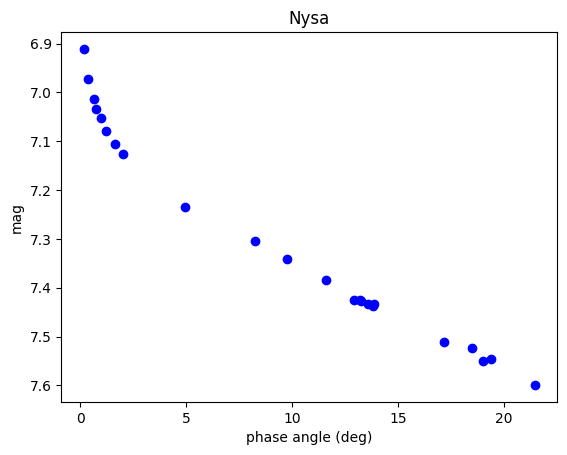

In [3]:
g,p1=plt.subplots(1,1)
p1.plot(nysa['phase'],nysa['V'],'bo')
p1.set_title('Nysa')
p1.set_xlabel('phase angle (deg)')
p1.set_ylabel('mag')
p1.invert_yaxis()

## Fit HG

Define the fit function.

In [4]:
# Photometric system from sbpy package, photometry submodule
def pf(xdeg,par1,par2):
    return pm.HG.evaluate(xdeg*np.pi/180,par1,par2)

# Sum-of-squares
def sse_fun(x,data):
    return sum([(pf(d[0],x[0],x[1])-d[1])**2 for d in data])

# Fit function
def fit_fun(data, x0=[6,0.12]):
    cv = ({'type': 'ineq', 'fun': lambda x: x[1]},
          {'type': 'ineq', 'fun': lambda x: 1-x[1]})
    return sco.minimize(sse_fun,x0,args=data,constraints=cv,method='COBYLA')

In [5]:
# Do fit
res = fit_fun(nysa)
print("RMS of H,G-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f} and G={:1.6f}".format(res.x[0],res.x[1]))

RMS of H,G-fit is 0.00663333
Fitted H=6.9567 and G=0.512114


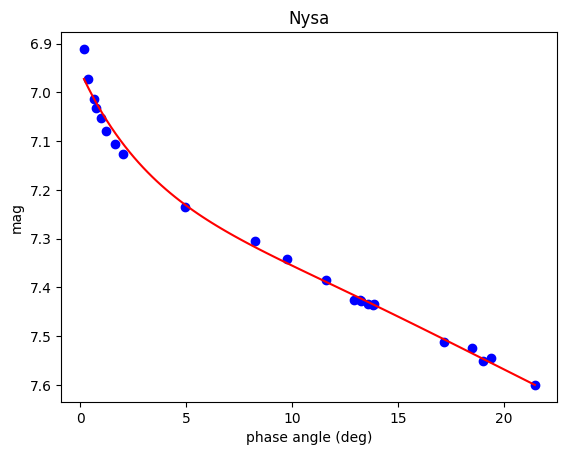

In [6]:
# Plot result
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1]) for x in fx])
g,p1=plt.subplots(1,1)
p1.plot(nysa['phase'],nysa['V'],'bo')
p1.plot(fx,fy,'r')
p1.set_title('Nysa')
p1.set_xlabel('phase angle (deg)')
p1.set_ylabel('mag')
p1.invert_yaxis()

## Fit HG12

Define the fit function.

In [7]:
# Photometric system from sbpy package, photometry submodule
def pf(xdeg,par1,par2):
    return pm.HG12.evaluate(xdeg*np.pi/180,par1,par2)

# Sum-of-squares
def sse_fun(x,data):
    return sum([(pf(d[0],x[0],x[1])-d[1])**2 for d in data])

# Fit function
def fit_fun(data, x0=[6,0.12]):
    cv1 = ({'type': 'ineq', 'fun': lambda x: x[1]+0.0818919},
           {'type': 'ineq', 'fun': lambda x: 0.2-x[1]})
    cv2 = ({'type': 'ineq', 'fun': lambda x: x[1]-0.2},
           {'type': 'ineq', 'fun': lambda x: 0.909714-x[1]})
    res1 = sco.minimize(sse_fun,[6,0.12],args=data,constraints=cv1,method='COBYLA')
    res2 = sco.minimize(sse_fun,[6,0.32],args=data,constraints=cv2,method='COBYLA')
    if(res1.fun < res2.fun):
        return res1
    else:
        return res2

In [8]:
# Do fit
res = fit_fun(nysa)
print("RMS of H,G12-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f} and G12={:1.6f}".format(res.x[0],res.x[1]))
print("  meaning that G1={:1.6f} and G2={:1.6f}".format(pm.HG12._G12_to_G1(res.x[1]),pm.HG12._G12_to_G2(res.x[1])))

RMS of H,G12-fit is 0.00196114
Fitted H=6.8952 and G12=-0.064504
  meaning that G1=0.013088 and G2=0.689001


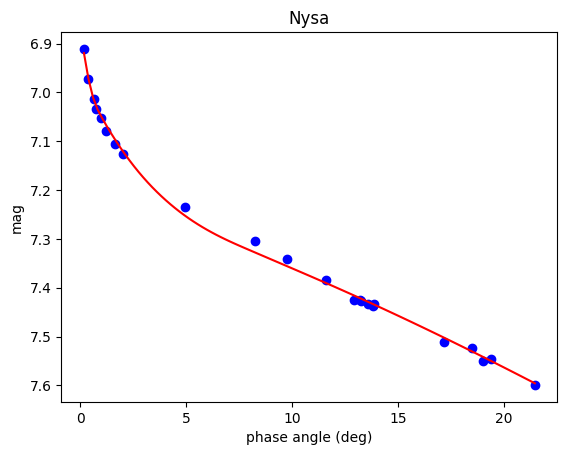

In [9]:
# Plot result
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1]) for x in fx])
g,p1=plt.subplots(1,1)
p1.plot(nysa['phase'],nysa['V'],'bo')
p1.plot(fx,fy,'r')
p1.set_title('Nysa')
p1.set_xlabel('phase angle (deg)')
p1.set_ylabel('mag')
p1.invert_yaxis()

## Fit HG12*

Define the fit function.

In [10]:
# Photometric system from sbpy package, photometry submodule
def pf(xdeg,par1,par2):
    return pm.HG12_Pen16.evaluate(xdeg*np.pi/180,par1,par2)

# Sum-of-squares
def sse_fun(x,data):
    return sum([(pf(d[0],x[0],x[1])-d[1])**2 for d in data])

# Fit function
def fit_fun(data, x0=[6,0.12]):
    cv = ({'type': 'ineq', 'fun': lambda x: x[1]},
          {'type': 'ineq', 'fun': lambda x: 1-x[1]})
    res = sco.minimize(sse_fun,x0,args=data,constraints=cv,method='COBYLA')
    return res

In [11]:
# Do fit
res = fit_fun(nysa)
print("RMS of H,G12*-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f} and G12={:1.6f}".format(res.x[0],res.x[1]))
print("  meaning that G1={:1.6f} and G2={:1.6f}".format(pm.HG12_Pen16._G12_to_G1(res.x[1]),pm.HG12_Pen16._G12_to_G2(res.x[1])))

RMS of H,G12*-fit is 0.19110857
Fitted H=6.6982 and G12=0.000000
  meaning that G1=0.000000 and G2=0.535134


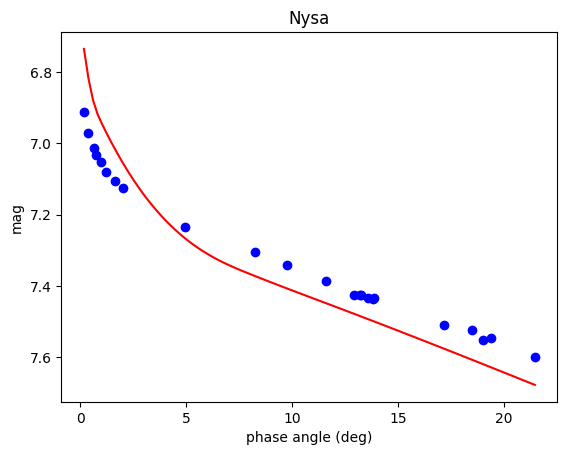

In [12]:
# Plot result
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1]) for x in fx])
g,p1=plt.subplots(1,1)
p1.plot(nysa['phase'],nysa['V'],'bo')
p1.plot(fx,fy,'r')
p1.set_title('Nysa')
p1.set_xlabel('phase angle (deg)')
p1.set_ylabel('mag')
p1.invert_yaxis()

Nysa is E-type and not well covered with the G12*-system, therefore the fit is not very good.

## Fit HG1G2

Define the fit function.

In [13]:
# Photometric system from sbpy package, photometry submodule
def pf(xdeg,par1,par2,par3):
    return pm.HG1G2.evaluate(xdeg*np.pi/180,par1,par2,par3)

# Sum-of-squares
def sse_fun(x,data):
    return sum([(pf(d[0],x[0],x[1],x[2])-d[1])**2 for d in data])

# Fit function
def fit_fun(data, x0=[6,0.1,0.1]):
    cv = ({'type': 'ineq', 'fun': lambda x: x[1]},
          {'type': 'ineq', 'fun': lambda x: x[2]},
          {'type': 'ineq', 'fun': lambda x: 1-x[1]-x[2]})
    res = sco.minimize(sse_fun,x0,args=data,constraints=cv,method='COBYLA')
    return res

In [14]:
# Do fit
res = fit_fun(nysa)
print("RMS of H,G1G2-fit is {:2.8f}".format(res.fun))
print("Fitted H={:1.4f}, G1={:1.6f}, and G2={:1.6f}".format(res.x[0],res.x[1],res.x[2]))

RMS of H,G1G2-fit is 0.00200390
Fitted H=6.9118, G1=0.093060, and G2=0.648455


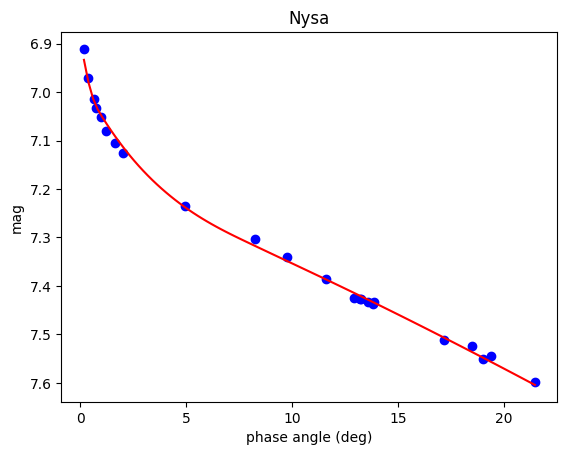

In [15]:
# Plot result
fx=np.linspace(nysa['phase'][0],nysa['phase'][-1],100)
fy=np.array([pf(x,res.x[0],res.x[1],res.x[2]) for x in fx])
g,p1=plt.subplots(1,1)
p1.plot(nysa['phase'],nysa['V'],'bo')
p1.plot(fx,fy,'r')
p1.set_title('Nysa')
p1.set_xlabel('phase angle (deg)')
p1.set_ylabel('mag')
p1.invert_yaxis()